# **Finding Lane Lines on the Road**

This pipeline takes in a video and indetifies the lane lines in it 

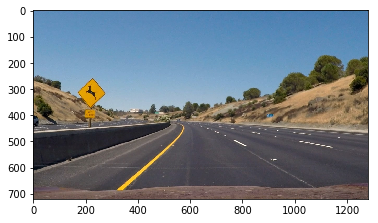

In [1]:
#importing the libraries. This block of the code gives the sample visualization of the data

import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


# Folders for the input test images and output images
folder_out= '/Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/output_images/'
folder_in= '/Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/test_images/'



#filename= 'straight_lines1'
#filename= 'straight_lines2'
#filename= 'test1'
filename= 'test2'
#filename= 'test3'
#filename= 'test4'
#filename= 'test5'
#filename= 'test6'

ext ='.jpg'

image = mpimg.imread(folder_in+filename+ext)


plt.imshow(image)

img = cv2.imread(folder_in+filename+ext)
img_size = (img.shape[1], img.shape[0])

In [2]:
# loading up the distortion coefficients from the Camera Calibration code results
dist_pickle = pickle.load( open( "/Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


Text(0.5,1,'Undistorted Image')

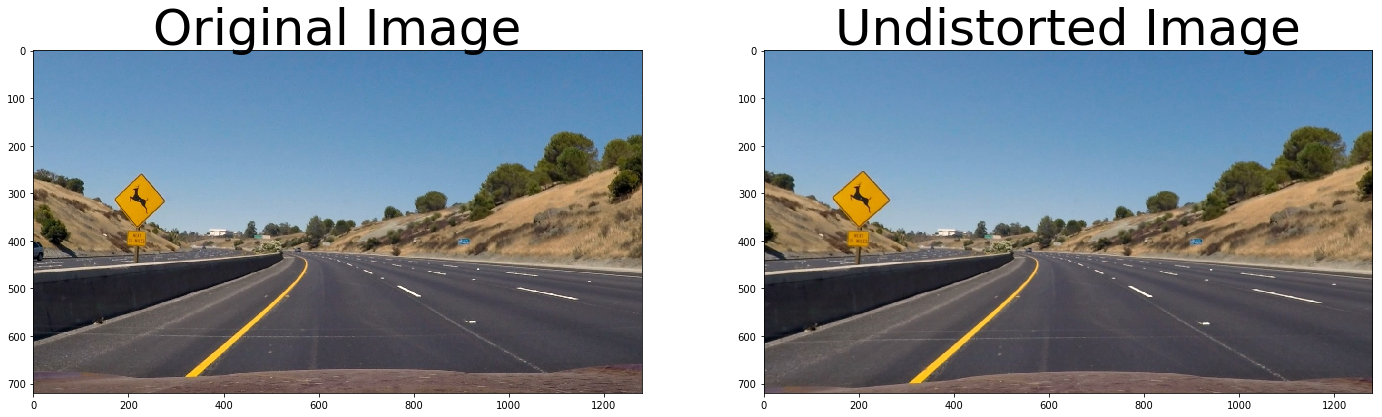

In [3]:
# undistort function using the imported distortion coefficients
def undist(img, mtx, dist):
    undist_image= cv2.undistort(img,mtx,dist,None,mtx)
    return undist_image


undist_img = undist (image, mtx, dist)
fig = plt.figure(figsize=(24, 9))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(image)
ax1.set_title('Original Image',fontsize=50)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image',fontsize=50)

True

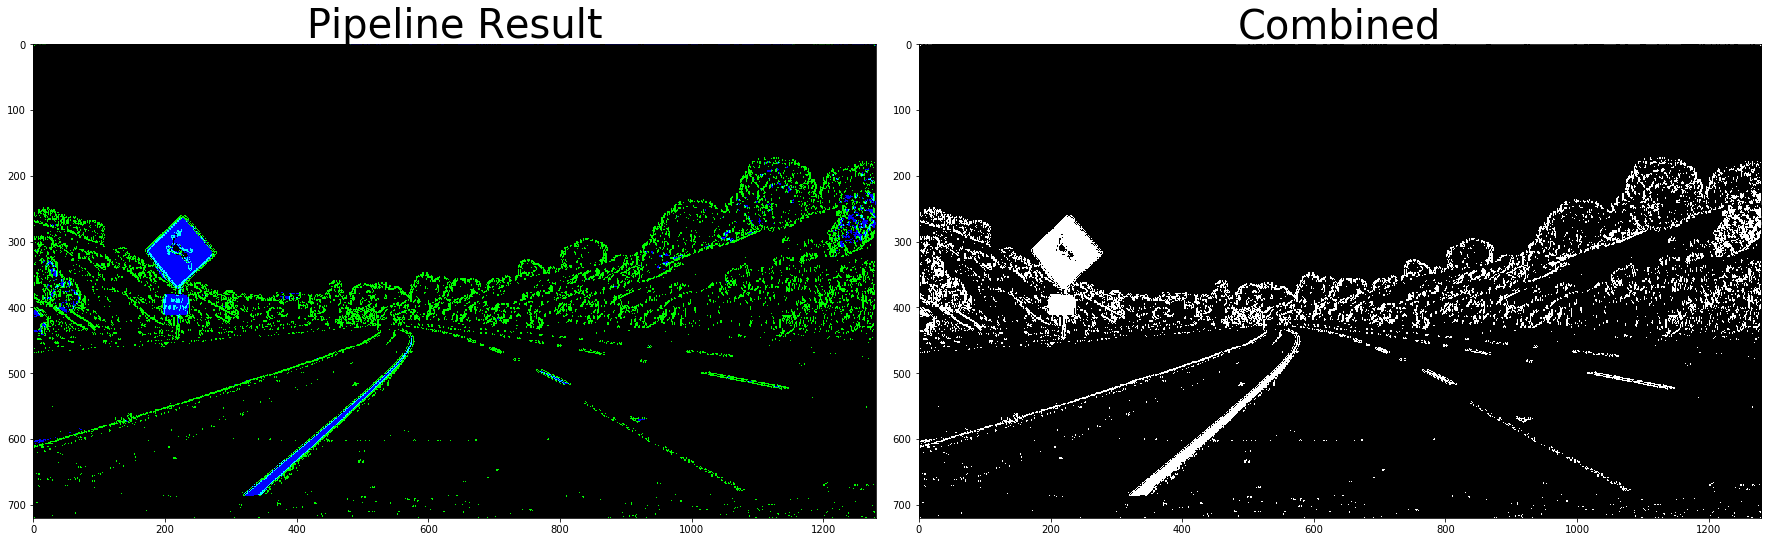

In [4]:
# thresholding function provides thresholding in X gradient and S channel on HLS space

def thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >=sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

result1, result2 = thresholding(image)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#
ax1.imshow(result1)
ax1.set_title('Pipeline Result', fontsize=40)
#
ax2.imshow(result2,cmap='gray')
ax2.set_title('Combined', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#
cv2.imwrite(folder_out+filename+'_thresholded'+ext,result2)


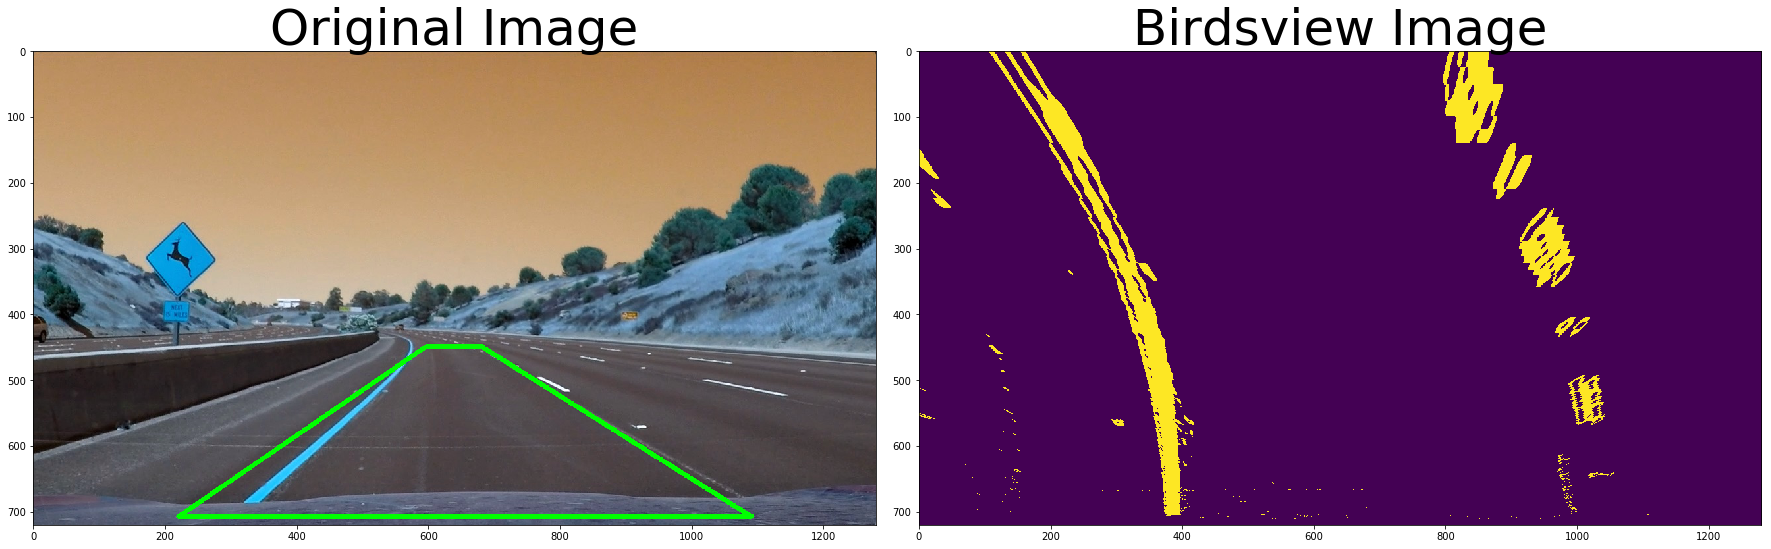

In [5]:
# The source and destination points for applying perspective transformation

src= np.float32(
        [[220,707],
         [597,448],
         [680,448],
        [1091,707]])

dst= np.float32(
        [[320,707],
        [320,10],
        [970,10] ,
        [970,707]])  

# Perspective transform for birdseye
def perspect(img,src,dst):
    M= cv2.getPerspectiveTransform(src,dst)
    Minv= cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,img_size,flags =  cv2.INTER_LINEAR)
    return warped, M, Minv

image = undist(img,mtx,dist)
result1, result2 = thresholding(image)
#    warped_im, transf =perspect(bird,src,dst)
binary_warped, M, Minv= perspect(result2,src,dst)

vertices = np.array([[220,707],[597,448],[680,448],[1091,707]], np.int32)
vertices = vertices.reshape((-1,1,2))
bird = cv2.polylines(img, [vertices], True, (0,255,0),5)

# Plot image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(bird)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped)
ax2.set_title('Birdsview Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#

In [6]:
# Full pipeline for image processing. This function calls out all the image processing functions- 
#undistortion, thresholding and perspective transformation 

def imagepro(img):
    
    image = undist(img,mtx,dist)
    result1, result2 = thresholding(image)
#    warped_im, transf =perspect(bird,src,dst)
    binary_warped, M, Minv= perspect(result2,src,dst)
    
    return image, binary_warped, Minv

In [7]:

# Function to apply the sliding window algorithm for the first time to find the lane lines
# It takes the processed image as an input and ouputs the fit coefficients and the lane pixels
def findlanefirst(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit= None
    right_fit= None
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds
    
  

[-5.08239566e-04  7.12583551e-01  1.34938550e+02] [-3.75500700e-04  5.76909058e-01  8.06929908e+02]


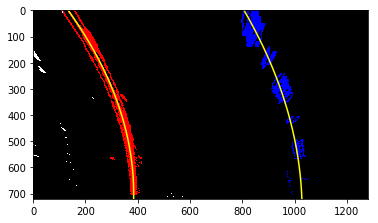

In [8]:
# Function to plot the lane lines as the result of findlanefirst().  
#It takes in the lane pixels and fit the second degree curve.
# The fitted curve is shown in yellow.

def plot_full_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):    
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Sample Y vaules to generate the x values by the fitted curve equation
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Left lane pixels in red and right lane pixels in blue
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

img = cv2.imread(folder_in+filename+ext)
image, binary_warped, Minv = imagepro(img)
left_fit, right_fit, left_lane_inds, right_lane_inds= findlanefirst(binary_warped)
print(left_fit, right_fit)
plot_full_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)


In [9]:
# function to find the lane once you already have your first fits using findlanefirst()
def find_lane(binary_warped, left_fit, right_fit):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit= None
    right_fit= None
    if len(leftx)!=0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)!=0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

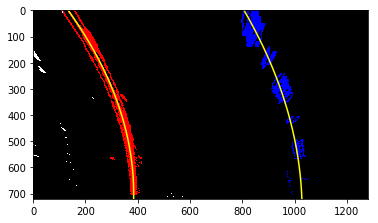

In [10]:
#Function to plot the lane lines as the result of findlane().  

def plot_full_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):    
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_full_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)


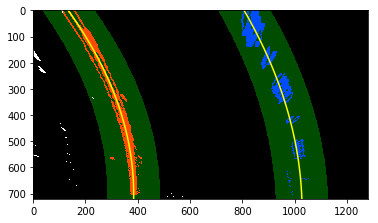

In [11]:
# Function to take in output for the lane finding functions and draw continuous lane lines along with the search window area

def plot_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds): 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    margin = 100
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_search(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)


In [12]:
# finding the curvature and car position

def curv_dist(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):
# Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = binary_warped.shape[0]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
       
    if len(leftx) != 0 and len(rightx) != 0:
    #print (1/np.absolute(2*right_fit_cr[0]))
    # Calculate the new radii of curvature
     # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # Finding the position of car based on the assumtion that the camera is mounted on the center of the vehicle
    if right_fit is not None and left_fit is not None:
        car_px = binary_warped.shape[1]/2
        l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        
        lane_center = (l+r) /2
        
        # Changing it to world coordinates
        center_dist = (car_px - lane_center) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist

left_curverad, right_curverad, center_dist= curv_dist(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

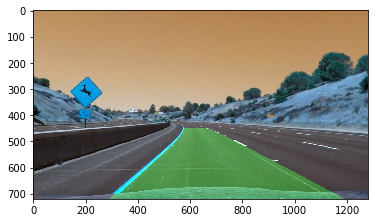

In [13]:
# This function takes in the image, the lane fits and the inverse matrix from the perspective function.
# It warps the lane lines back onto the original image.

def plotback(binary_warped, image, left_fit, right_fit, Minv):

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

result= plotback(binary_warped, image, left_fit, right_fit, Minv)
plt.imshow(result)

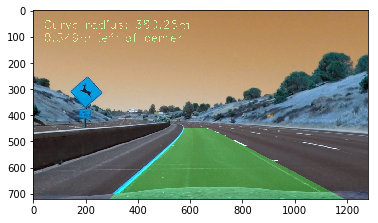

In [14]:
# This function writes down the curvature and distance from center data on the image

def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155))
    direction = ''
    # positive center distance right and negative center distance left
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155))
    return new_img
curv_rad = (abs(left_curverad)+abs(right_curverad))/2
new_img = draw_data(result, curv_rad, center_dist)
plt.imshow(new_img)

In [15]:
# Line class to store all the relevant data about a particular lane line

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #Counter for number
        self.linenum=0
    
    # Function to take in the current fit to produce an average fit from the previous 5 fits
    def add_fit(self, fit, ind):
        if self.linenum > 15:
            if fit is not None:
                self.detected= True
                self.current_fit.append(fit)
                if len(self.current_fit)>15:
                    self.current_fit= self.current_fit[len(self.current_fit)-15:]
                self.best_fit = np.average (self.current_fit, axis=0)

            else:
                self.detected = False
                if len(self.current_fit)>0:
                    self.best_fit= np.average(self.current_fit, axis=0)
        else:
            if fit is not None:
                self.detected= True
                self.current_fit.append(fit)
                if len(self.current_fit)>1:
                    self.current_fit= self.current_fit[len(self.current_fit)-1:]
                self.best_fit = np.average (self.current_fit, axis=0)

            else:
                self.detected = False
                if len(self.current_fit)>0:
                    self.best_fit= np.average(self.current_fit, axis=0)



In [16]:
# Main function to pass to the video pipeline

def process_image(img):
    image1= np.copy(img)
    
    image, binary_warped, Minv= imagepro(image1)
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds= findlanefirst(binary_warped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds= find_lane(binary_warped, left_line.best_fit, right_line.best_fit)
        
    #Checking for curvature and distance
    
    if left_fit is not None and right_fit is not None:
        
        lcurv,rcurv, dist = curv_dist(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
        if abs(lcurv) < 100 or abs(rcurv)<100:
           left_fit= None
           right_fit= None
        
        
#     else: 
        y_eval = image.shape[0]
            
        l = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        r = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        lane_size= abs(l-r)
        
        # Checking for the lane line width
        if lane_size <400 or lane_size>1000:
            left_fit = None
            right_fit=  None
            
    left_line.add_fit(left_fit,left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
        
    if left_line.best_fit is not None and right_line.best_fit is not None:
        img_out = plotback(binary_warped, image, left_line.best_fit, right_line.best_fit, Minv)
        lcurv,rcurv, dist = curv_dist(binary_warped, left_line.best_fit, right_line.best_fit,left_lane_inds, right_lane_inds)
        img_out = draw_data(img_out, (lcurv+rcurv)/2, dist)
    else:
        img_out = image
        
    left_line.linenum=left_line.linenum+1
    right_line.linenum=right_line.linenum+1
        
    return img_out

In [17]:
left_line= Line()
right_line= Line()


# Input and output video file folders
inputvideo= '/Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/project_video.mp4'
outputvideo= '/Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/project_output_video1.mp4'
# creating a clip and applying the process_image function to every frame of the video
myclip = VideoFileClip(inputvideo)
clip = myclip.fl_image(process_image)

%time clip.write_videofile(outputvideo, audio=False)

[MoviePy] >>>> Building video /Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/project_output_video1.mp4
[MoviePy] Writing video /Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/project_output_video1.mp4


100%|█████████▉| 1260/1261 [03:21<00:00,  6.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/architrastogi/Documents/advanced_lane_lines/CarND-Advanced-Lane-Lines-master/project_output_video1.mp4 

CPU times: user 3min 37s, sys: 29 s, total: 4min 6s
Wall time: 3min 23s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputvideo))